# Comparison of dimensionality reduction algorithms

We'll now look at ALL the dimensionality reduction algorithms we've looked at so far and compare them using several datasets.

1. "Mouse" and "Psuedotime" artificial datasets
2. A commonly used machine learning [dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/).

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


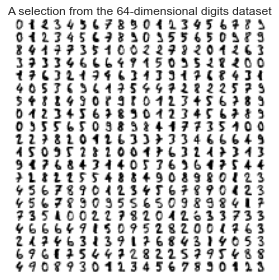

In [10]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011

plt.close('all')

digits = datasets.load_digits() #n_class=n_class)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30


PALETTE = sns.color_palette('husl', n_colors=len(np.unique(digits.target)))

# PALETTE = sns.diverging_palette(220, 20, n=10, center='dark')
digits_row_colors = [PALETTE[i] for i in digits.target]

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=PALETTE[int(y[i])],
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset');
sns.despine(bottom=True, left=True)

In [4]:
from time import time

import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import seaborn as sns
sns.set(context='notebook', style='white')

%matplotlib inline

np.random.seed(2016)

n_samples = 10
n_genes = 20

half_genes = int(n_genes/2)
half_samples = int(n_samples/2)
size = n_samples * n_genes

genes = ['Gene_{}'.format(str(i+1).zfill(2)) for i in range(n_genes)]
samples = ['Sample_{}'.format(str(i+1).zfill(2)) for i in range(n_samples)]

mouse_data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)

# Add biological variance
mouse_data.iloc[:half_samples, :half_genes] += 1
mouse_data.iloc[:half_samples, half_genes:] += -1
mouse_data.iloc[half_samples:, half_genes:] += 1
mouse_data.iloc[half_samples:, :half_genes] += -1

# Z_score within genes
mouse_data = (mouse_data - mouse_data.mean())/mouse_data.std()

# Biological samples
mouse_groups = pd.Series(dict(zip(mouse_data.index, (['Mouse_01'] * int(n_samples/2)) + (['Mouse_02'] * int(n_samples/2)))), 
                         name="Mouse")
mouse_to_color = dict(zip(['Mouse_01', 'Mouse_02'], ['lightgrey', 'black']))
mouse_colors = [mouse_to_color[mouse_groups[x]] for x in samples]

# Gene colors
gene_colors = (['SeaGreen'] * half_genes) + (['MediumPurple'] * half_genes)
mouse_row_colors = mouse_colors
mouse_col_colors = gene_colors 

g = sns.clustermap(mouse_data, row_colors=mouse_row_colors, col_cluster=False, row_cluster=False, 
                   linewidth=0.5, col_colors=mouse_col_colors,
                   cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);
g.fig.suptitle('Mouse data')

np.random.seed(2016)

n_samples = 10
n_genes = 20

half_genes = int(n_genes/2)
half_samples = int(n_samples/2)
size = n_samples * n_genes

genes = ['Gene_{}'.format(str(i+1).zfill(2)) for i in range(n_genes)]
samples = ['Sample_{}'.format(str(i+1).zfill(2)) for i in range(n_samples)]

pseudotime_data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)

# Add "psueodotime"
pseudotime_data.iloc[:, :half_genes] = pseudotime_data.iloc[:, :half_genes].add(np.square(np.arange(n_samples)/2), axis=0)
pseudotime_data.iloc[:, half_genes:] = pseudotime_data.iloc[:, half_genes:].add(np.square(np.arange(n_samples)[::-1]/2), axis=0)


# Normalize genes using z-scores
pseudotime_data = (pseudotime_data - pseudotime_data.mean())/pseudotime_data.std()

pseudotime_row_colors = sns.color_palette('BrBG', n_colors=n_samples)
pseudotime_col_colors = sns.color_palette("PRGn", n_colors=n_genes)
tidy = pseudotime_data.unstack().reset_index()
tidy = tidy.rename(columns={'level_0': 'Gene', 'level_1': "Sample", 0:'Normalized Expression'})
tidy.head()

g = sns.factorplot(data=tidy, hue='Gene', palette=pseudotime_col_colors, x='Sample', 
                   y='Normalized Expression', aspect=2)
# g.map(plt.plot, x='Sample', y='Normalized Expression')


g = sns.clustermap(pseudotime_data, row_colors=pseudotime_row_colors, col_cluster=False, row_cluster=False, 
                   linewidth=0.5, col_colors=pseudotime_col_colors,
                   cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);
g.fig.suptitle('Pseudotime data')

In [ ]:
shalek2013_expression = pd.read_csv('https://github.com/YeoLab/shalek2013/raw/master/expression.csv')
shalek2013_expression_feature = pd.read_csv('https://github.com/YeoLab/shalek2013/raw/master/expression_feature.csv')
shalek2013_metadata = pd.read_csv('https://github.com/YeoLab/shalek2013/raw/master/metadata.csv')

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


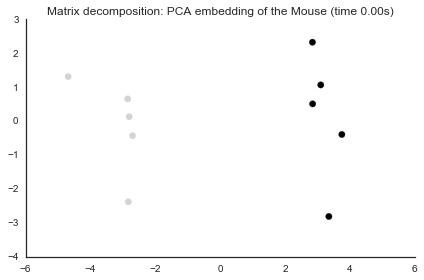

In [18]:
methods = [
#     'Clustering: complete', 
#            'Clustering: single', 
#            'Clustering: average', 
#            'Clustering: ward', 
#            'Clustering: centroid',
           'Matrix decomposition: PCA',
           'Matrix decomposition: ICA',
           'Manifold learning: MDS',
           'Manifold learning: t-SNE'
          ]


def explore_clustering(dataset, method):
    if dataset == 'Mouse':
        data = mouse_data
        row_colors = mouse_row_colors
        col_colors = mouse_col_colors
    elif dataset == 'Pseudotime':
        data = pseudotime_data
        row_colors = pseudotime_row_colors
        col_colors = pseudotime_col_colors
    elif dataset == 'Digits':
        data = digits.data
        row_colors = digits_row_colors
        col_colors = None
    # Copy the full name of the method
    fullname = str(method)
    if method.startswith('Clustering'):
        method = method.split()[-1]
        t0 = time()
        g = sns.clustermap(data, row_colors=row_colors, method=method,
                           xticklabels=[], yticklabels=[])
        g.fig.suptitle('{} linkage of the digits (time {:.2f}s)'.format(fullname, time()-t0))
        
    else:
        n_components = 2
        max_iter = 100
        random_state = 0
        n_init = 1
        if method.endswith('PCA'):
            estimator = decomposition.PCA(n_components=n_components)
        elif method.endswith('ICA'):
            estimator = decomposition.FastICA(max_iter=max_iter, n_components=n_components, 
                                              random_state=random_state)
        elif method.endswith('MDS'):
            estimator =  manifold.MDS(n_init=n_init, max_iter=max_iter, random_state=random_state)
        elif method.endswith('t-SNE'):
            estimator = manifold.TSNE(n_components, init='pca', random_state=random_state)
        
        t0 = time()
        smushed = estimator.fit_transform(data)
        title = "{} embedding of the {} (time {:.2f}s)".format(fullname, dataset, time() - t0)
        if dataset == 'Digits':
            plot_embedding(smushed, title)
            # Plot a legend by hand
            fig, ax = plt.subplots(figsize=(1, 1))
            for digit, color in zip(digits.target, PALETTE):
                ax.bar(0, 0, color=color, label=digit)
            ax.patches = []
            ax.legend(loc='center')
            ax.axis('off')
        else:
            fig, ax = plt.subplots()
            
            ax.scatter(smushed[:, 0], smushed[:, 1], color=row_colors, s=40)
            ax.set(title=title)
            sns.despine()


ipywidgets.interact(explore_clustering,
                    dataset=ipywidgets.Dropdown(options=['Mouse', 'Pseudotime', 'Digits'], value='Mouse', 
                                               description='Dataset'),
                    metric=ipywidgets.Dropdown(options=['euclidean', 'cityblock', ], value='euclidean', 
                                               description='Distance metric'),
                    method=ipywidgets.Dropdown(options=methods, value='Matrix decomposition: PCA', 
                                               description='Unsupervised learning method'),);

## Discussion

1. Which algorithms best represent the large difference between biological groups in the Mouse data?
2. Which algorithms best represent the continuous underlying structure of the Pseudotime data? 
3. Which algorithms maintain the continuum of features between the digits?
4. Which algorithms make it easy to distinguish between clusters of digits?
5. **Which had a bigger influence on the interpretation, the algorithms or the data?**